# Anomaly Detection
Many applications require being able to decide whether a new observation belongs to the same distribution as existing observations(it is an inlier), or should be considered as different(it is an outlier). Often, this ability is used to clean real data sets. 
Two important distinction must be made:
### Novelty detection:
 	The training data is not polluted by outliers, and we are interested in detecting anomalies in new observations.

### Outlier detection:
    The training data contains outliers, and we need to fit the central mode of the training data, ignoring the deviant observations.

In [2]:
import pandas
import numpy

# need this for using pandas built-in plotting facility
import matplotlib.pyplot as plt
%matplotlib inline

# please visit 'http://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py'
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.ensemble import GradientBoostingClassifier


pandas.set_option('display.max_rows', 10)
pandas.set_option('display.max_columns', 10)

# set a fixed seed for numpy pseudo random generator
numpy.random.seed(100)

# build an mm scaler for later use
scaler = MinMaxScaler(feature_range=(-1, 1))

In [3]:
# read a compressed csv file
data = pandas.read_csv("./datasets/creditcardfraud.zip", 
                        compression='zip', header=0,  sep=',')

# tell me how much memory 'data' is using?
data.memory_usage()/(2**20), data.shape

(Index     0.000076
 Time      2.172905
 V1        2.172905
 V2        2.172905
 V3        2.172905
             ...   
 V26       2.172905
 V27       2.172905
 V28       2.172905
 Amount    2.172905
 Class     2.172905
 Length: 32, dtype: float64, (284807, 31))

In [4]:
# let's peek into the data a always
data

# data.columns

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,...,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,...,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,...,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,...,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,...,0.502292,0.219422,0.215153,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,...,0.250034,0.943651,0.823731,0.77,0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,...,-0.395255,0.068472,-0.053527,24.79,0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,...,-0.087371,0.004455,-0.026561,67.88,0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,...,0.546668,0.108821,0.104533,10.00,0


In [5]:
# show me a crude descrition of the data
data.describe()

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,...,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,...,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,...,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,...,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,...,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,...,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,...,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


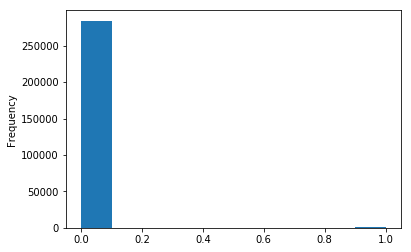

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class
541,406.0,-2.312227,1.951992,-1.609851,3.997906,...,0.177840,0.261145,-0.143276,0.00,1
623,472.0,-3.043541,-3.157307,1.088463,2.288644,...,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,...,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,...,-0.657488,-0.827136,0.849573,59.00,1
6329,7519.0,1.234235,3.019740,-4.304597,4.732795,...,0.566797,-0.010016,0.146793,1.00,1
...,...,...,...,...,...,...,...,...,...,...,...
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,...,0.788395,0.292680,0.147968,390.00,1
280143,169347.0,1.378559,1.289381,-5.004247,1.411850,...,0.739467,0.389152,0.186637,0.76,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,...,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,...,0.606116,0.884876,-0.253700,245.00,1


In [19]:
plt.figure()

# show me the historgram for 'Class'
data['Class'].plot.hist()

plt.show()

# how many 1s do we have in 'Class'?
data[data['Class'] == 1]

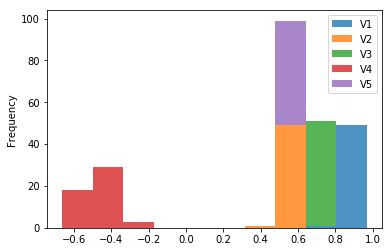

In [7]:
plt.figure()

subset_features = ['V1', 'V2', 'V3', 'V4', 'V5']

scaled_subset =pandas.DataFrame(
    scaler.fit_transform(data[subset_features]),
    columns=subset_features)

# show me the historgram for 'Class'
scaled_subset.iloc[0:50].plot.hist(stacked=True, 
                                    bins=10, alpha=0.8)

plt.show()

In [8]:
# print out the column names
data.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [20]:
features = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 
'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15',
'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 
'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

target = ['Class']

data[data['Class'] == numpy.nan]

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class


In [21]:
data.Class.dropna(inplace=True)
X = data[features]
Y = data[target]

In [11]:
X_scaled = pandas.DataFrame(scaler.fit_transform(X), columns=features)

# first column is not sclaed, the second one is scaled
pandas.concat([X.loc[0:100, 'V6'],
               X_scaled.loc[0:100, 'V6']], axis="columns")

,V6,V6
0,0.462388,-0.464663
1,-0.082361,-0.475617
2,1.800499,-0.437756
3,1.247203,-0.448882
4,0.095921,-0.472032
...,...,...
96,1.365515,-0.446503
97,-0.343000,-0.480858
98,0.258495,-0.468763
99,-0.990609,-0.493880


In [27]:
# Using an RFE object to rank each feature
cls = GradientBoostingClassifier()
rfe = RFE(estimator=cls, n_features_to_select=3, step=1.0)
margin = 1000
rfe.fit(X_scaled.iloc[0:margin], Y.iloc[0:margin])

# less is better(1 is the best)
rfe.ranking_
#rfe.n_features_
#rfe.estimator_
#rfe.get_support()

# make a dictionay object in sahpe of {'feature': 'rank'}
rank = dict(zip(features, rfe.ranking_))
rank

#cls.feature_importances_

/home/user/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'Amount': 1,
 'V1': 27,
 'V10': 18,
 'V11': 14,
 'V12': 1,
 'V13': 13,
 'V14': 12,
 'V15': 11,
 'V16': 10,
 'V17': 8,
 'V18': 9,
 'V19': 16,
 'V2': 26,
 'V20': 17,
 'V21': 15,
 'V22': 7,
 'V23': 1,
 'V24': 6,
 'V25': 5,
 'V26': 4,
 'V27': 3,
 'V28': 2,
 'V3': 25,
 'V4': 24,
 'V5': 23,
 'V6': 22,
 'V7': 21,
 'V8': 20,
 'V9': 19}

In [30]:
X.Amount.describe()
data[(X.Amount > 10) & (Y.Class == 1)]

,Time,V1,V2,V3,V4,...,V26,V27,V28,Amount,Class
623,472.0,-3.043541,-3.157307,1.088463,2.288644,...,-0.145362,-0.252773,0.035764,529.00,1
4920,4462.0,-2.303350,1.759247,-0.359745,2.330243,...,-0.542628,0.039566,-0.153029,239.93,1
6108,6986.0,-4.397974,1.358367,-2.592844,2.679787,...,-0.657488,-0.827136,0.849573,59.00,1
6971,9064.0,-3.499108,0.258555,-4.489558,4.853894,...,0.296367,1.985913,-0.900452,1809.68,1
8845,12095.0,-4.727713,3.044469,-5.598354,5.928191,...,-0.033590,-1.331777,0.705698,30.39,1
...,...,...,...,...,...,...,...,...,...,...,...
276864,167338.0,-1.374424,2.793185,-4.346572,2.400731,...,-0.414209,0.454982,0.096711,349.08,1
279863,169142.0,-1.927883,1.125653,-4.518331,1.749293,...,0.788395,0.292680,0.147968,390.00,1
280149,169351.0,-0.676143,1.126366,-2.213700,0.468308,...,0.471111,0.385107,0.194361,77.89,1
281144,169966.0,-3.113832,0.585864,-5.399730,1.817092,...,0.606116,0.884876,-0.253700,245.00,1


In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [31]:
# create test and train data
selected_features = ['V12', 'V23', 'Amount']
X_train, X_test, y_train, y =\
train_test_split(X[selected_features], Y, test_size=0.1)
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)
y_hat = rfc.predict(X_test)

/home/user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """


In [32]:
# show me the report
print(metrics.classification_report(y_hat, y))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00     28447
          1       0.55      0.85      0.67        34

avg / total       1.00      1.00      1.00     28481



# Precision, Recall, F Score, Support,  Accuracy (In Binary Classification)

![Precion and Recall](https://upload.wikimedia.org/wikipedia/commons/2/26/Precisionrecall.svg)

![F_x Score](https://wikimedia.org/api/rest_v1/media/math/render/svg/49d1ff4917ee4c464f6efbee08735b4a8694e8c0)

<!-- ![TN, TP, FP ansd FN](https://upload.wikimedia.org/wikipedia/commons/6/65/Binary-classification-labeled.svg)
-->

![Accuracy](https://wikimedia.org/api/rest_v1/media/math/render/svg/e2e427ec6dcf2d7882c3bbdc659a8204cba59dcc)

In [17]:
# very very suspicious!
print(metrics.accuracy_score(y_hat, y))

0.998735999438


In [18]:
# data is very unbiased it seems!
a = data[data.Class == 1].shape[0]
b = data.shape[0]
a/b

0.001727485630620034